In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
# read file
stock_path = "C:/Users/acer/Desktop/LAB/lab_2.csv"
stock_df = pd.read_csv(stock_path)
stock_df=stock_df.fillna(0)

In [3]:
train_set = stock_df[:2200]
test_set = stock_df[2200:]
print(train_set.shape)
print(test_set.shape)

(2200, 12)
(238, 12)


In [4]:
# every features in range(0 , 1)
train_set.describe()

,K value,D value,MACD,William,SMA,WMA,Momentum,RSI,A/D 0,CCI,Close r/f
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,0.478459,0.494744,0.515782,0.515950,0.425581,0.426475,0.464374,0.492458,0.445859,0.463808,1.000000
std,0.242761,0.231248,0.128572,0.292113,0.297391,0.296803,0.101128,0.251304,0.278231,0.159410,0.964113
min,0.004943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.272646,0.306148,0.453617,0.258398,0.180373,0.181665,0.419330,0.292431,0.208334,0.351748,0.000000
50%,0.469031,0.482729,0.512733,0.520003,0.364709,0.364416,0.461561,0.500000,0.415185,0.467025,1.000000
75%,0.691137,0.682273,0.585561,0.777773,0.712705,0.712135,0.514771,0.687486,0.687456,0.572115,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [5]:
# print the number of rise , flat , fall data
print("Train set Rise: %.4f"%(len(train_set[train_set["Close r/f"] == 2])*100 / len(train_set)))
print("Train set Flat: %.4f"%(len(train_set[train_set["Close r/f"] == 1])*100 / len(train_set)))
print("Train set Fall: %.4f"%(len(train_set[train_set["Close r/f"] == 0])*100 / len(train_set)))
print("Test set Rise: %.4f"%(len(test_set[test_set["Close r/f"] == 2])*100 / len(test_set)))
print("Test set Flat: %.4f"%(len(test_set[test_set["Close r/f"] == 1])*100 / len(test_set)))
print("Test set Fall: %.4f"%(len(test_set[test_set["Close r/f"] == 0])*100 / len(test_set)))


Train set Rise: 46.4545
Train set Flat: 7.0909
Train set Fall: 46.4545
Test set Rise: 49.5798
Test set Flat: 2.5210
Test set Fall: 47.8992


In [6]:
# declear training features data
features = []
for i in range(30,len(train_set)):
    x = train_set[i-30:i][["K value ","D value","William","MACD","SMA","WMA","Momentum","RSI","A/D 0","CCI"]].values
    features.append(x.tolist())
features = torch.FloatTensor(features)
print("size of feature: ",features.size())

# declear trainging labels data
labels = []
for i in range(31,len(train_set)+1):
    x = train_set[i-1:i]["Close r/f"]
    labels.append(x.tolist())
labels = torch.LongTensor(labels).view(-1)
print("size of label: ",labels.size())

size of feature:  torch.Size([2170, 30, 10])
size of label:  torch.Size([2170])


In [7]:

#delcear testing features and labels

test_features = []
for i in range(30,len(test_set)):
    x = test_set[i-30:i][["K value ","D value","William","MACD","SMA","WMA","Momentum","RSI","A/D 0","CCI"]].values
    test_features.append(x.tolist())
test_features = torch.FloatTensor(test_features)
print("size of test features: ",test_features.size())

test_labels = []
for i in range(31,len(test_set)+1):
    x = test_set[i-1:i]["Close r/f"]
    test_labels.append(x.tolist())
test_labels = torch.FloatTensor(test_labels).view(-1)
print("size of test labels: ",test_labels.size())

size of test features:  torch.Size([208, 30, 10])
size of test labels:  torch.Size([208])


In [8]:
def DAE(features,labels,test_features,test_labels):
    #hy parameter
    EPOCH = 20
    BATCH_SIZE = 64
    TIME_STEP = 30
    INPUT_SIZE = 10
    LR = 0.001
    
    #Mini-Batch

    torch_dataset = Data.TensorDataset(features,labels)
    train_loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = BATCH_SIZE,
        num_workers = 2,
        shuffle=True,
    )
    
    class autoencoder(torch.nn.Module):
        def __init__(self):
            super(autoencoder, self).__init__()
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(TIME_STEP * INPUT_SIZE, 64),
                torch.nn.ReLU(True),
                torch.nn.Linear(64, 12), 
                torch.nn.ReLU(True), 
                torch.nn.Linear(12, 3))
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(3, 12),
                torch.nn.ReLU(True),
                torch.nn.Linear(12, 64),
                torch.nn.ReLU(True), 
                torch.nn.Linear(64, TIME_STEP * INPUT_SIZE), 
                torch.nn.Tanh())

        def forward(self, x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x
    model = autoencoder()
    print(model)
    
    # define optimizer and loss function 
    optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=0.0005)
    # adject learning rate . when loss don't fall , lr = lr * factor  , min lr = 0.0001
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.9,min_lr=0.0001)
    # crossentroy loss 
    loss_func = torch.nn.MSELoss()
    '''
    Training 
    '''
    LOSS = []
    TEST_LOSS = []
    for epoch in range(EPOCH):
        loss_total = 0
        for step,(inputs,targets) in enumerate(train_loader):
            inputs = inputs.view(-1,TIME_STEP * INPUT_SIZE)
            #reshape the features to (batch,time_step*input_size)
            inputs_n = inputs.view(-1,TIME_STEP * INPUT_SIZE)


            inputs_n =  inputs_n + torch.randn(TIME_STEP * INPUT_SIZE)*0.5
            # Clip the images to be between 0 and 1
            inputs_n = np.clip( inputs_n, 0., 1.)


            # start trainnig 
            output = model(inputs_n)
            # calculate loss  (cross entroy)
            loss = loss_func(output,inputs)
            # clear the gradients of all optimized variables(from last training)
            optimizer.zero_grad()

            # back propagation
            loss.backward()
            optimizer.step()
            # sum of loss
            loss_total = loss_total + loss

            # print training info every 10 steps
            if((step+1) %10 == 0):
                # average of loss in 10 steps
                avg = loss_total / 10
                LOSS.append(avg.tolist())

                # test data
                test_features = torch.Tensor(test_features).view(-1,30*10)
                out = model(test_features)
                test_loss = loss_func(out,test_features)
                TEST_LOSS.append(test_loss.tolist())
                # print the epoch , steps , average loss , accuracy 
                print("Epoch: %4d|steps: %4d|Train Avg Loss: %.4f |Test Loss: %4f"
                      %(epoch+1,step+1,avg,test_loss))

                # inital variable
                loss_total = 0
        # updata learning rate
        #scheduler.step(loss)
        
    x = np.linspace(1,60,60)
    LOSS = np.array(LOSS)
    TEST_LOSS = np.array(TEST_LOSS)
    plt.plot(x,LOSS)
    plt.xlabel("steps")
    plt.ylabel("Loss")
    plt.title("Denoise autoencoder")
    plt.plot(x,TEST_LOSS)
    plt.show()

    features = features.view(-1,TIME_STEP*INPUT_SIZE)
    features = model(features)
    features = features.detach().view(-1,TIME_STEP,INPUT_SIZE)
    return features

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=12, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=300, bias=True)
    (5): Tanh()
  )
)
Epoch:    1|steps:   10|Train Avg Loss: 0.2630 |Test Loss: 0.207820
Epoch:    1|steps:   20|Train Avg Loss: 0.1920 |Test Loss: 0.117046
Epoch:    1|steps:   30|Train Avg Loss: 0.1028 |Test Loss: 0.063802
Epoch:    2|steps:   10|Train Avg Loss: 0.0596 |Test Loss: 0.042570
Epoch:    2|steps:   20|Train Avg Loss: 0.0562 |Test Loss: 0.041447
Epoch:    2|steps:   30|Train Avg Loss: 0.0557 |Test Loss: 0.041378
Epoch:    3|steps:   10|Train A

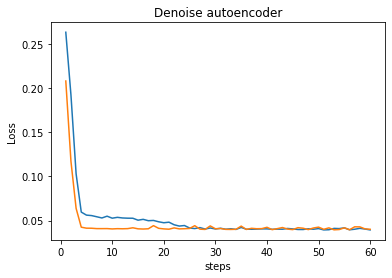

In [9]:
DAE_features = DAE(features.detach(),labels.detach(),test_features.detach(),test_labels.detach())

In [10]:
#hy parameter
torch.manual_seed(1)
EPOCH = 10000
BATCH_SIZE = 32
TIME_STEP = 30
INPUT_SIZE = 10
LR = 0.001

In [11]:

#Mini-Batch

torch_dataset = Data.TensorDataset(DAE_features,labels)
train_loader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 2,
    shuffle=True,
)

In [12]:

#define NN architecture


class RNN(torch.nn.Module):   
    def __init__(self):
        super(RNN,self).__init__()
        # define lstm layer
        self.lstm = torch.nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=128,         
            num_layers=1,
            batch_first=True, 
        )
        # dropout layer
        #self.dropout = torch.nn.Dropout(p = 0.0)
        # Dense layer
        #self.hidden  =torch.nn.Linear(64,16)
        self.out = torch.nn.Linear(128,3)
        self.activate = torch.nn.Softmax(dim = 1)
        
    def forward(self,x):
        lstm_out,(h_n,h_c) = self.lstm(x,None)
        #hidden_out = self.hidden(lstm_out[:,-1,:])
        # only need last output of lstm layer
        out = self.out(lstm_out[:,-1,:])
        #out = self.activate(out)
        return out


In [13]:
model = RNN()
print(model)

RNN(
  (lstm): LSTM(10, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=3, bias=True)
  (activate): Softmax(dim=1)
)


In [14]:
# define optimizer and loss function 
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=0.0000)
# adject learning rate . when loss don't fall , lr = lr * factor  , min lr = 0.0001
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.9,min_lr=0.0001)
# crossentroy loss 
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
'''
Training 
'''
LOSS = []
ACC = []
TRAIN_ACC = []
for epoch in range(EPOCH):
    loss_total = 0
    for step,(inputs,targets) in enumerate(train_loader):
        inputs = inputs.view(-1,TIME_STEP,INPUT_SIZE)
        # start trainnig 
        output = model(inputs)
        # calculate loss  (cross entroy)
        loss = loss_func(output,targets)
        # clear the gradients of all optimized variables(from last training)
        optimizer.zero_grad()
        
        # back propagation
        loss.backward()
        optimizer.step()
        # sum of loss
        loss_total = loss_total + loss
        
        # print training info every 30 steps
        if((step+1) %30 == 0):
            # average of loss in 30 steps
            avg = loss_total / 30
            LOSS.append(avg.tolist())
            
            # calculate the accuracy of training 
            pred_train_y = torch.max(output, 1)[1].data.numpy()
            train_accuracy = float((pred_train_y == targets.numpy()).astype(int).sum()) / float(targets.numpy().size)
            TRAIN_ACC.append(train_accuracy)
            
            # calculate the accuracy of using testing data as inputs
            test_output = model(test_features.view(-1,TIME_STEP,INPUT_SIZE))
            pred_test_y = torch.max(test_output, 1)[1].data.numpy()
            test_accuracy = float((pred_test_y == test_labels.numpy()).astype(int).sum()) / float(test_labels.numpy().size)
            ACC.append(test_accuracy)
            
            # print the epoch , steps , average loss , accuracy 
            print("Epoch: %4d|steps: %4d|Train Avg Loss: %.4f |Train set Accuracy: %.4f |Test set Accuracy: %.4f|lr = %.5f"
                  %(epoch+1,step+1,avg,train_accuracy,test_accuracy,optimizer.param_groups[0]['lr']))
            
            # inital variable
            loss_total = 0
    # updata learning rate
    scheduler.step(loss)
        


Epoch:    1|steps:   30|Train Avg Loss: 0.9558 |Train set Accuracy: 0.3125 |Test set Accuracy: 0.4808|lr = 0.00100
Epoch:    1|steps:   60|Train Avg Loss: 0.9153 |Train set Accuracy: 0.4062 |Test set Accuracy: 0.4808|lr = 0.00100
Epoch:    2|steps:   30|Train Avg Loss: 0.9078 |Train set Accuracy: 0.5000 |Test set Accuracy: 0.4808|lr = 0.00100
Epoch:    2|steps:   60|Train Avg Loss: 0.9019 |Train set Accuracy: 0.4375 |Test set Accuracy: 0.4952|lr = 0.00100
Epoch:    3|steps:   30|Train Avg Loss: 0.8950 |Train set Accuracy: 0.5312 |Test set Accuracy: 0.4808|lr = 0.00100
Epoch:    3|steps:   60|Train Avg Loss: 0.9145 |Train set Accuracy: 0.6250 |Test set Accuracy: 0.5385|lr = 0.00100
Epoch:    4|steps:   30|Train Avg Loss: 0.8981 |Train set Accuracy: 0.4375 |Test set Accuracy: 0.4808|lr = 0.00100
Epoch:    4|steps:   60|Train Avg Loss: 0.9091 |Train set Accuracy: 0.4688 |Test set Accuracy: 0.4808|lr = 0.00100
Epoch:    5|steps:   30|Train Avg Loss: 0.8907 |Train set Accuracy: 0.5000 |Test

Epoch:   37|steps:   30|Train Avg Loss: 0.8969 |Train set Accuracy: 0.2812 |Test set Accuracy: 0.4952|lr = 0.00090
Epoch:   37|steps:   60|Train Avg Loss: 0.9124 |Train set Accuracy: 0.4688 |Test set Accuracy: 0.5288|lr = 0.00090
Epoch:   38|steps:   30|Train Avg Loss: 0.9023 |Train set Accuracy: 0.2812 |Test set Accuracy: 0.4952|lr = 0.00090
Epoch:   38|steps:   60|Train Avg Loss: 0.8885 |Train set Accuracy: 0.5625 |Test set Accuracy: 0.4952|lr = 0.00090
Epoch:   39|steps:   30|Train Avg Loss: 0.9032 |Train set Accuracy: 0.3125 |Test set Accuracy: 0.5048|lr = 0.00090
Epoch:   39|steps:   60|Train Avg Loss: 0.8997 |Train set Accuracy: 0.3438 |Test set Accuracy: 0.4952|lr = 0.00090
Epoch:   40|steps:   30|Train Avg Loss: 0.9056 |Train set Accuracy: 0.5625 |Test set Accuracy: 0.4808|lr = 0.00090
Epoch:   40|steps:   60|Train Avg Loss: 0.8823 |Train set Accuracy: 0.4375 |Test set Accuracy: 0.4952|lr = 0.00090
Epoch:   41|steps:   30|Train Avg Loss: 0.9056 |Train set Accuracy: 0.5312 |Test